# Exploraton of UMAP 
An a comparison with PCA for dimensionality reduction, visulaization and density-based clustering

Get this from https://github.com/rmartinshort/JournalClub

In [8]:
# See https://umap-learn.readthedocs.io/en/latest/ for details
import umap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
#for clustering, see https://hdbscan.readthedocs.io/en/latest/index.html for details
import hdbscan

In [11]:
#See https://ipyvolume.readthedocs.io/en/latest/index.html
import ipyvolume as ipv

In [12]:
#See https://github.com/dunovank/jupyter-themes
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='oceans16',context='talk', fscale=1.4, spines=False, gridlines='--')
%matplotlib inline

### The effects of UMAP parameter variation

The two most important parameters are n_neighbors and min_dist

Note that for this swiss roll problem, UMAP is overkill - local linear embedding (LLE) will work just as well and it will also be faster

In [13]:
from sklearn.datasets import make_swiss_roll

In [14]:
n_samples = 10000

swiss_3d, swiss_val = make_swiss_roll(
    n_samples=n_samples,
    noise=0.1,
    random_state=1)

swiss_3d = swiss_3d[swiss_val.argsort()][::-1]
x,y,z = swiss_3d.T

In [15]:
palette = sns.color_palette('viridis',n_colors=n_samples)
ipv.quickscatter(x,y,z,size=1,color=palette,maker='sphere')

### The effect of n_neighbors

n_neighbors controls the extent to which local vs. global structure controls the shape that is learned. The larger this value, the larger the numver of points are used to learn the shape of the manifold

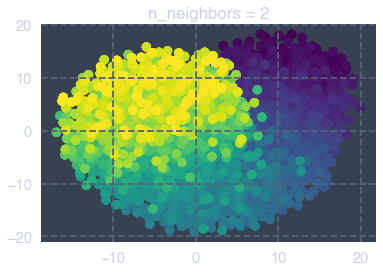

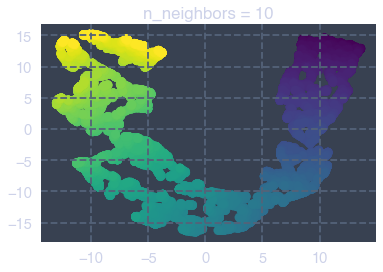

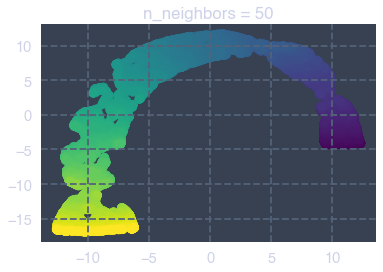

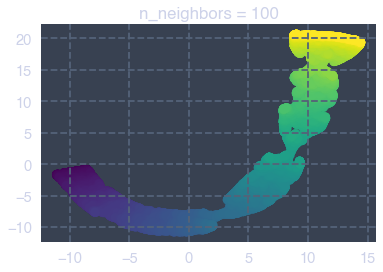

In [16]:
n_neighbors_list = [2,10,50,100]

for n in n_neighbors_list:
    
    umap_fit = umap.UMAP(
        n_neighbors=n,
        min_dist=0,
        n_components=2,
        metric="euclidean"
    ).fit(swiss_3d)
    
    swiss_transformed = umap_fit.transform(swiss_3d)
    plt.scatter(swiss_transformed[:,0],swiss_transformed[:,1],c=palette)
    plt.title('n_neighbors = %i' %n)
    plt.show()

### The effect of min_dist 

This controls how tightly UMAP is allowed to pack points together. For clustering it is advised to keep it small

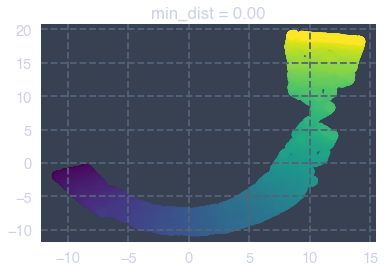

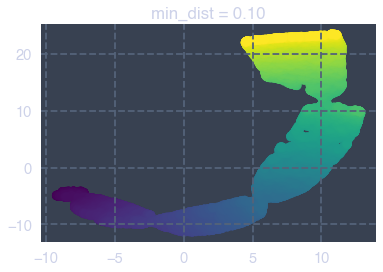

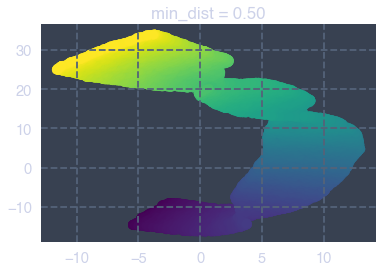

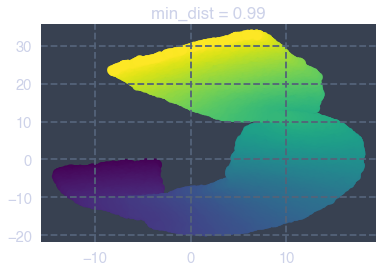

In [17]:
min_dist_list = [0,0.1,0.5,0.99]

for m in min_dist_list:
    
    umap_fit = umap.UMAP(
        n_neighbors=100,
        min_dist=m,
        n_components=2,
        metric="euclidean"
    ).fit(swiss_3d)
    
    swiss_transformed = umap_fit.transform(swiss_3d)
    plt.scatter(swiss_transformed[:,0],swiss_transformed[:,1],c=palette)
    plt.title('min_dist = %.2f' %m)
    plt.show()

### A real world example where UMAP is very powerful

In [19]:
%%time
#https://www.openml.org/d/554
mnist = fetch_openml('mnist_784')

CPU times: user 19.2 s, sys: 596 ms, total: 19.8 s
Wall time: 20.2 s


In [20]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [21]:
np.unique(mnist.target)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [22]:
def plot_dataset_decomp(embedding,title):
    
    '''Plot a dataset that has been reduced to 2D'''
    
    fig, ax = plt.subplots(figsize=(12, 10))
    color = mnist.target.astype(int)
    plt.scatter(
        embedding[:, 0], embedding[:, 1], c=color, cmap=plt.cm.get_cmap('rainbow', 10), s=0.8
    )
    plt.title(title, fontsize=18)
    plt.colorbar()

## Fit 2D PCA 

In [23]:
%%time
pca = PCA(n_components=2).fit(mnist.data)
pca_embedding = pca.transform(mnist.data)

CPU times: user 2.21 s, sys: 430 ms, total: 2.64 s
Wall time: 1.82 s


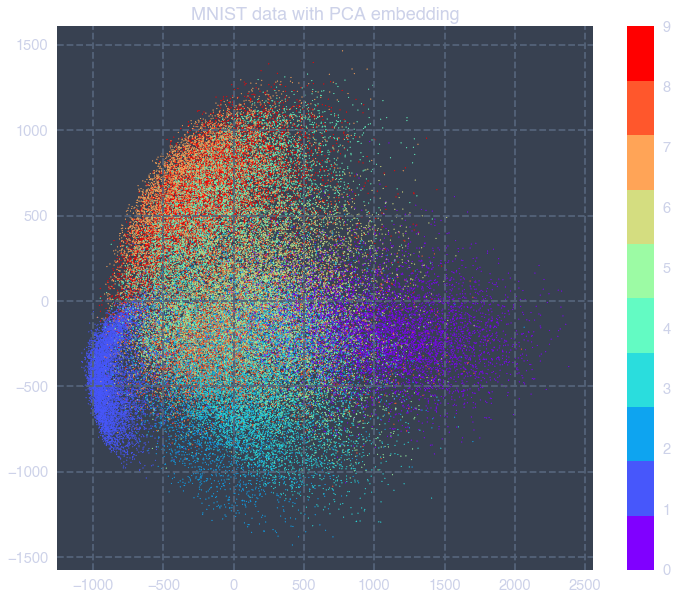

In [24]:
plot_dataset_decomp(pca_embedding,"MNIST data with PCA embedding")

In [25]:
pca.explained_variance_ratio_

array([0.09746116, 0.07155445])

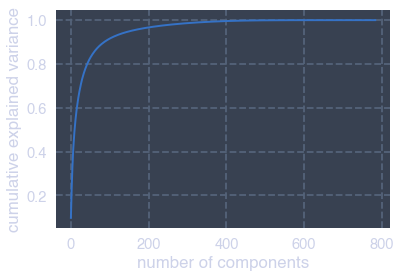

In [27]:
pca = PCA().fit(mnist.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Fit 2D UMAP to mnist data

In [28]:
%%time 
umap_fit = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean"
).fit(mnist.data)

CPU times: user 8min 50s, sys: 3.84 s, total: 8min 54s
Wall time: 8min 58s


In [29]:
umap_embedding = umap_fit.transform(mnist.data)

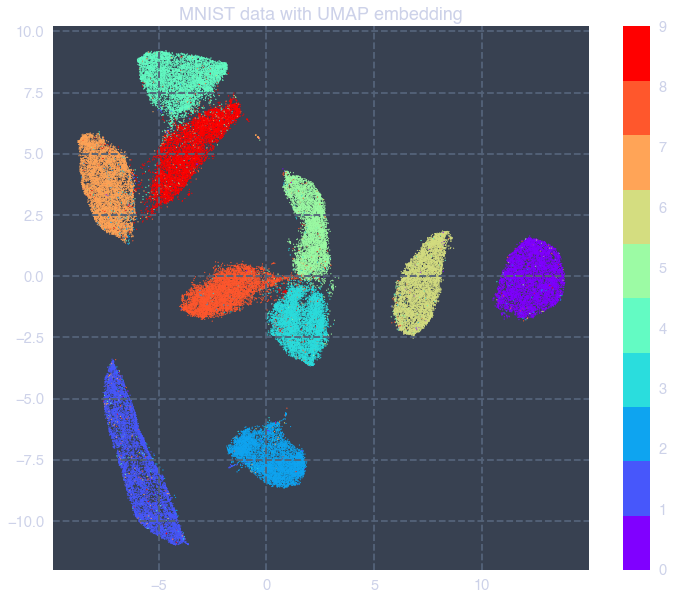

In [30]:
plot_dataset_decomp(umap_embedding,"MNIST data with UMAP embedding")

## Fit 3D UMAP to mnist data

First we sample ~10% of the original dataset, which makes the interactive plot easier to navigate

In [31]:
sampled_mnist = mnist.data[np.random.choice(np.arange(len(mnist.data)),size=int(0.1*len(mnist.data)))]

In [32]:
%%time
umap_fit_3D = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,
    metric="euclidean"
).fit(sampled_mnist)

CPU times: user 13 s, sys: 119 ms, total: 13.1 s
Wall time: 13 s


In [33]:
umap_embedding_3D = umap_fit_3D.transform(sampled_mnist)

In [34]:
ipv.quickscatter(umap_embedding_3D[:,0], umap_embedding_3D[:,1], umap_embedding_3D[:,2],size=1, marker="sphere")

## Choose parameters for optimal density-based clustering

We want to choose a larger n-neighbors to ensure coherent clusters, and a smaller min_dist because density is used by the clustering algorithm

In [56]:
%%time
umap_fit_cluster = umap.UMAP(
    n_neighbors=30,
    min_dist=0,
    n_components=2,
    random_state=42,
    metric="euclidean"
).fit(mnist.data)

umap_embedding_cluster = umap_fit_cluster.transform(mnist.data)

CPU times: user 22min 25s, sys: 10.2 s, total: 22min 36s
Wall time: 22min 44s


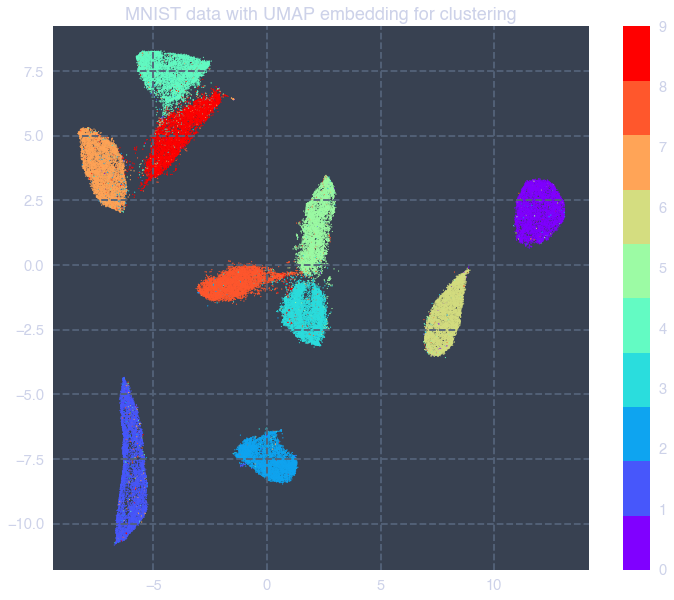

In [58]:
plot_dataset_decomp(umap_embedding_cluster,"MNIST data with UMAP embedding for clustering")

In [59]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(umap_embedding_cluster)

In [60]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [61]:
clustered = (labels >= 0)

#This is the proportation of data that we clustered
100.0*np.sum(clustered) / mnist.data.shape[0]

99.43428571428572

In [62]:
adjusted_rand_score(mnist.target[clustered], labels[clustered]), adjusted_mutual_info_score(mnist.target[clustered], labels[clustered])

(0.9329037015629361, 0.9196263048271051)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


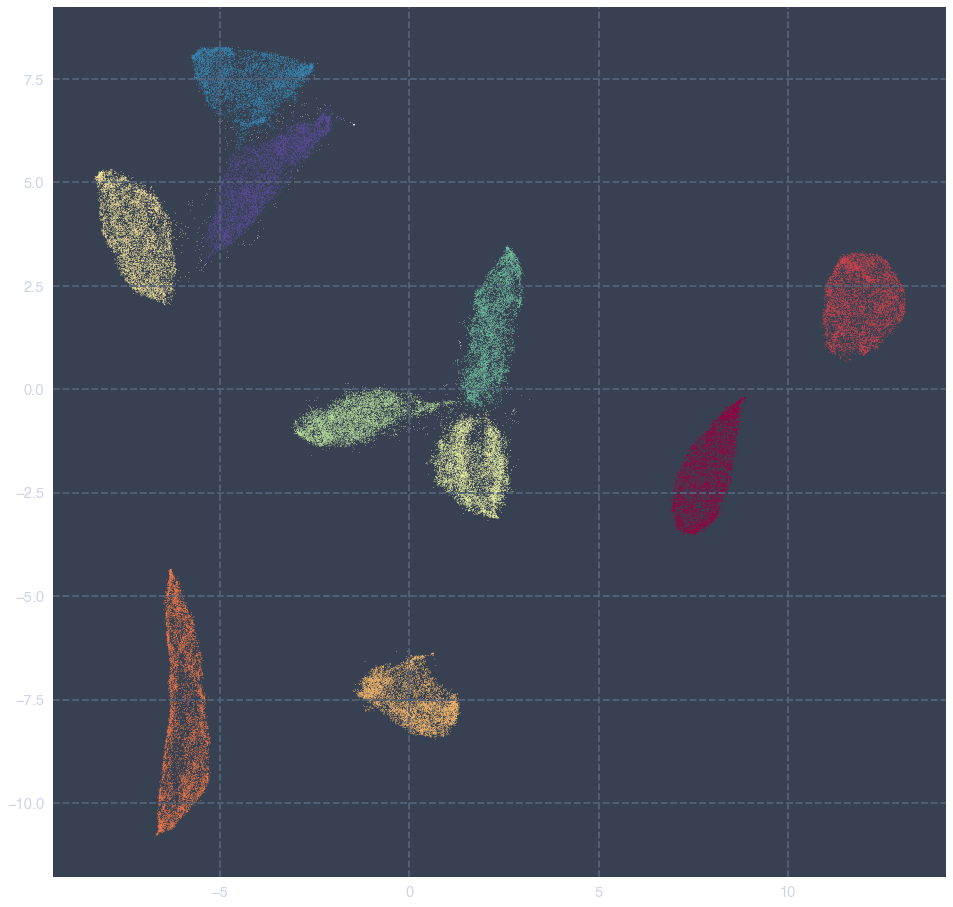

In [67]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
clustered = (labels >= 0)
ax.scatter(umap_embedding_cluster[~clustered, 0],
            umap_embedding_cluster[~clustered, 1],
            c=(1, 1, 1),
            s=0.2,
            alpha=0.5)
ax.scatter(umap_embedding_cluster[clustered, 0],
            umap_embedding_cluster[clustered, 1],
            c=labels[clustered],
            s=0.2,
            cmap='Spectral');